## [Forecasting non-stationary time series](https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH07/CH07.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [25]:
df_init = pd.read_csv('../data/SBER_250914_250915.csv', sep=';')
df = df_init['<CLOSE>'].tail(200)
df.rename('close', inplace=True)
df.reset_index(drop=True, inplace=True)

df

0      302.25
1      302.26
2      302.28
3      302.23
4      302.47
        ...  
195    302.36
196    302.37
197    302.34
198    302.44
199    302.55
Name: close, Length: 200, dtype: float64

In [56]:
train = df[:int(0.9*len(df))]
test = df[int(0.9*len(df)):]

print(len(train), len(test))

180 20


In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: pd.Series, order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in order_list:
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [57]:
from itertools import product

ps = range(0, 3, 1)
qs = range(0, 3, 1)

order_list = list(product(ps, qs))
order_list

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [58]:
result_df = optimize_ARIMA(train, order_list, 1)
result_df

C:\envs\vertr\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 0)",-384.637592
1,"(2, 0)",-384.527414
2,"(1, 1)",-384.442226
3,"(0, 2)",-384.334458
4,"(2, 1)",-382.781484
5,"(0, 1)",-382.759321
6,"(1, 2)",-382.460390
7,"(2, 2)",-381.260413
8,"(0, 0)",-377.335186


In [65]:
model = SARIMAX(train, order=(1,1,1))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  180
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 195.221
Date:                Mon, 27 Oct 2025   AIC                           -384.442
Time:                        19:50:48   BIC                           -374.880
Sample:                             0   HQIC                          -380.565
                                - 180                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5949      0.250      2.377      0.017       0.104       1.085
ma.L1         -0.3925      0.284     -1.383      0.167      -0.949       0.164
sigma2         0.0066      0.001     12.924      0.0

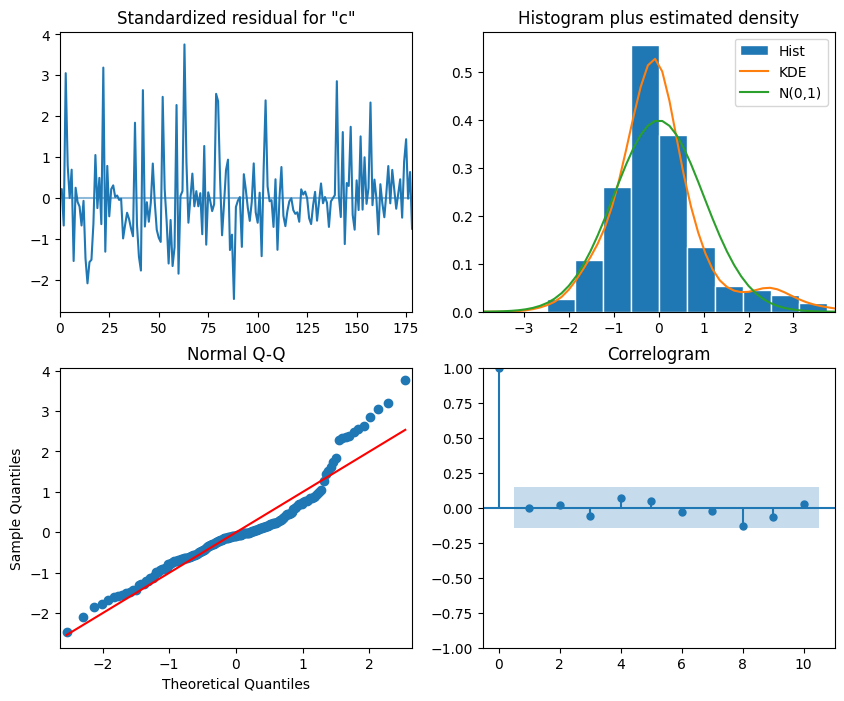

In [66]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [67]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,1.205853e-09,0.999972
2,1.503728e-09,1.000000
3,1.399878e-05,1.000000
4,1.066273e-04,1.000000
5,1.075283e-04,1.000000
6,1.134550e-04,1.000000
7,1.135350e-04,1.000000
8,1.955885e-04,1.000000
9,2.035844e-04,1.000000
10,2.242422e-04,1.000000


In [68]:
test

180    302.15
181    302.21
182    302.05
183    302.09
184    302.13
185    302.12
186    302.18
187    302.18
188    302.16
189    302.16
190    302.11
191    302.05
192    302.26
193    302.38
194    302.30
195    302.36
196    302.37
197    302.34
198    302.44
199    302.55
Name: close, dtype: float64

In [74]:
forecast = model_fit.get_forecast()
forecast.predicted_mean

#ARIMA_pred = model_fit.get_prediction(180, 199).predicted_mean
#ARIMA_pred

180    302.130306
dtype: float64

In [70]:
df_test = pd.DataFrame(test)
df_test['ARIMA_pred'] = ARIMA_pred

df_test

,close,ARIMA_pred
180,302.15,302.130306
181,302.21,302.130488
182,302.05,302.130596
183,302.09,302.130661
184,302.13,302.130699
185,302.12,302.130722
186,302.18,302.130735
187,302.18,302.130743
188,302.16,302.130748
189,302.16,302.130751


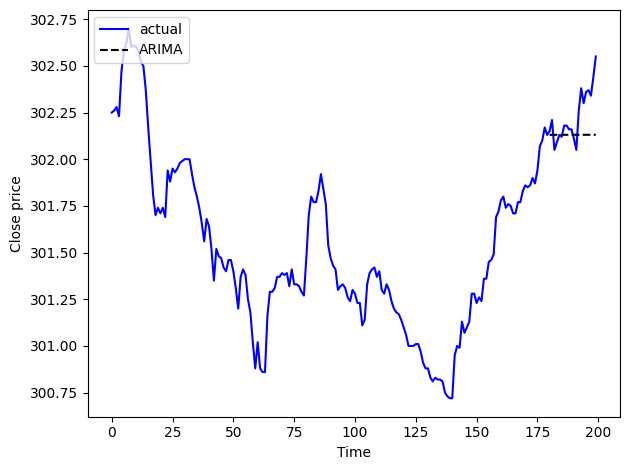

In [71]:
ig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_test['ARIMA_pred'], 'k--', label='ARIMA')

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Close price')

plt.tight_layout()


- [pmdarima](https://github.com/alkaline-ml/pmdarima)
- [statsforecast](https://github.com/Nixtla/statsforecast)
- [sktime](https://github.com/sktime/sktime)
- https://habr.com/ru/companies/otus/articles/511782/
- https://habr.com/ru/articles/822987/
- https://www.geeksforgeeks.org/python/complete-guide-to-sarimax-in-python/

### Books

Durbin, James, and Siem Jan Koopman. 2012. Time Series Analysis by State Space Methods: Second Edition. Oxford University Press.


